In [1]:
# Import
import os
from dataloader import BatchDataloader
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import trange, tqdm
import h5py
from torch.utils.data import TensorDataset, random_split, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils import pgd_attack, train_loop, eval_loop, train_loop_apgd, eval_loop_apgd
import utils
import ecg_plot
from models import ResNet1d, ResNet1dGELU
import ast
%matplotlib inline

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tqdm.write("Use device: {device:}\n".format(device=device))

Use device: cuda



In [3]:
batch_size = 32

In [16]:
# Load the data
dataset_path = '../ptb-xl'

path_to_csv, path_to_scp = dataset_path + '/ptbxl_database.csv', dataset_path + '/scp_statements.csv'
path_to_train, path_to_val, path_to_test = dataset_path + '/train.h5', dataset_path + '/val.h5', dataset_path + '/test.h5'

# Get labels
df = pd.read_csv(path_to_csv, index_col='ecg_id')
# Find how many unique ages there are, sorted
print(df['age'].unique())

# Print lowest age
print(df['age'].min())

# Print highest age
print(df['age'].max())

# Print second highest age
print(df['age'].sort_values().unique()[-2])

# Print how many there are of the following age groups 2-15 16-25, 26-40, 41-60, 61-80, 81-100
print(df[(df['age'] >= 2) & (df['age'] <= 15)].shape[0])
print(df[(df['age'] >= 18) & (df['age'] <= 25)].shape[0])
print(df[(df['age'] >= 26) & (df['age'] <= 40)].shape[0])
print(df[(df['age'] >= 41) & (df['age'] <= 60)].shape[0])
print(df[(df['age'] >= 61) & (df['age'] <= 80)].shape[0])
print(df[(df['age'] >= 81) & (df['age'] <= 100)].shape[0])

# print total number of samples
print(df.shape[0])

df = df[df['age'] != 300]
df.scp_codes = df.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path_to_scp, index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def has_key(dic, key_str):
    for key in dic.keys():
        if key == key_str:
            return 1
    return 0

# Apply diagnostic superclass
df['AF'] = df.scp_codes.apply(lambda x: has_key(x, 'AFIB'))

validation_fold = 9
test_fold = 10

# Load labels
train = df[(df.strat_fold != validation_fold) & (df.strat_fold != test_fold)]
val = df[df.strat_fold == validation_fold]
test = df[df.strat_fold == test_fold]

# change this for other labels
labels_train = train['age'].values
labels_val = val['age'].values
labels_test = test['age'].values

# Make them torch tensors
labels_train = torch.tensor(labels_train, dtype=torch.float32).reshape(-1,1)
labels_val = torch.tensor(labels_val, dtype=torch.float32).reshape(-1,1)
labels_test = torch.tensor(labels_test, dtype=torch.float32).reshape(-1,1)

# Define traces
traces_train = h5py.File(path_to_train, 'r')['tracings']
traces_val = h5py.File(path_to_val, 'r')['tracings']
traces_test = h5py.File(path_to_test, 'r')['tracings']

# Define dataloaders
train_dataloader = BatchDataloader(traces_train, labels_train, batch_size=batch_size)
val_dataloader = BatchDataloader(traces_val, labels_val, batch_size=batch_size)
test_dataloader = BatchDataloader(traces_test, labels_test, batch_size=batch_size)


[ 56.  19.  37.  24.  18.  54.  48.  55.  22.  20.  43.  58.  17.  49.
  41.  25.  40.  60.  42.  28.  45.  51.  23.  59.  35.  30.  29.  26.
  44.  31.  62.  21.  38.  27.  47.  46.  50.  64.  39. 300.  33.  57.
  68.  67.  52.  74.  81.  82.  70.  36.  85.  77.  73.  72.  61.  66.
  34.  53.  32.  84.  78.  83.  75.  79.  69.  63.  80.  87.  76.  71.
  65.  86.  88.  16.  89.   3.  12.  14.  15.   9.  11.  13.  10.   8.
   2.   5.   4.   6.   7.]
2.0
300.0
89.0
64
838
2105
7193
9137
2100
21799


In [5]:
# hyperparameters
learning_rate = 1e-3
weight_decay = 1e-2  
num_epochs = 20
adversarial_delay = 10 # Do not perform adversarial training until epoch x
start_eps = 1e-3
end_eps = 5e-2
loss_function = nn.MSELoss()

# for exponential schedule
eps_values = np.exp(np.linspace(np.log(start_eps), np.log(end_eps), num_epochs - adversarial_delay))
print(eps_values)

[0.001      0.00154445 0.00238533 0.00368403 0.00568981 0.00878764
 0.01357209 0.02096144 0.03237394 0.05      ]


In [6]:
pretrained_model_path = "models/code_model_10/latest.pth"
output_model_path = "../models/age/ptb_20_apgd_5e-2"
os.makedirs(output_model_path, exist_ok=True)

is_finetuning = False

In [7]:
# set seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [8]:
tqdm.write("Define model...")
model = ResNet1dGELU(input_dim=(12, 4096), n_classes=1, blocks_dim=[(64, 4096), (128, 1024), (196, 256), (256, 64), (320, 16)])#, kernel_size=3, dropout_rate=0.8

if is_finetuning:
    tqdm.write("Load pretrained model...")
    checkpoint = torch.load(pretrained_model_path, map_location=device)
    model.load_state_dict(checkpoint['model'])

model.to(device=device)
tqdm.write("Done!\n")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = None #torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

tqdm.write("Training...")
best_loss = np.Inf
# allocation
train_loss_all, valid_loss_all, adv_valid_loss_all = [], [], []
mse_all, mae_all = [], []

# loop over epochs
for epoch in trange(1, num_epochs + 1):
    # training loop
    adversarial = False if epoch <= adversarial_delay else True
    adv_eps = eps_values[epoch - adversarial_delay - 1] if epoch > adversarial_delay else 0

    train_loss = train_loop_apgd(epoch, train_dataloader, model, optimizer, loss_function, device, adversarial=adversarial, adv_eps=adv_eps, adv_iters=10, adv_restarts=1)
    # validation loop
    valid_loss, y_pred, y_true = eval_loop_apgd(epoch, val_dataloader, model, loss_function, device)
    adv_valid_loss, adv_y_pred, adv_y_true = eval_loop_apgd(epoch, val_dataloader, model, loss_function, device, adversarial=True, adv_eps=end_eps, adv_iters=10, adv_restarts=1)

    # collect losses
    train_loss_all.append(train_loss)
    valid_loss_all.append(valid_loss)
    adv_valid_loss_all.append(adv_valid_loss)

    # compute validation metrics for performance evaluation
    mse = mean_squared_error(y_true, y_pred)
    mse_all.append(mse)

    mae = mean_absolute_error(y_true, y_pred)
    mae_all.append(mae)

    # # save best model: here we save the model only for the lowest validation loss
    if valid_loss < best_loss:
        # Save model parameters
        torch.save({'model': model.state_dict()}, output_model_path + '/best.pth') 
        # Update best validation loss
        best_loss = valid_loss
        # statement
        model_save_state = "Best model -> saved"
    else:
        model_save_state = ""

    torch.save({'model': model.state_dict()}, output_model_path + '/latest.pth') 

    # Print message
    tqdm.write('Epoch {epoch:2d}: \t'
                'Train Loss {train_loss:.6f} \t'
                'Valid Loss {valid_loss:.6f} \t'
                'Adversarial Loss {adv_valid_loss:.6f} \t'
                'MSE {mse:.6f} \t'
               'MAE {mae:.6f} \t'
                '{model_save}'
                .format(epoch=epoch,
                        train_loss=train_loss,
                        valid_loss=valid_loss,
                        adv_valid_loss=adv_valid_loss,
                        mse=mse,
                        mae=mae,
                        model_save=model_save_state))

    # Update learning rate with lr-scheduler
    if lr_scheduler:
        lr_scheduler.step(valid_loss)

Define model...
Done!

Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Training Epoch  1:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch  1:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch  1: 	Train Loss 9.867885 	Valid Loss 5.966722 	Adversarial Loss 62.837983 	MSE 190.585648 	MAE 10.920835 	Best model -> saved


Training Epoch  2:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch  2:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch  2: 	Train Loss 5.932318 	Valid Loss 5.967323 	Adversarial Loss 52.401055 	MSE 190.707275 	MAE 10.910583 	


Training Epoch  3:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch  3:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch  3: 	Train Loss 5.463604 	Valid Loss 4.991749 	Adversarial Loss 64.082398 	MSE 159.559753 	MAE 9.815435 	Best model -> saved


Training Epoch  4:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch  4:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch  4: 	Train Loss 5.156471 	Valid Loss 5.112621 	Adversarial Loss 65.878037 	MSE 163.422607 	MAE 10.068139 	


Training Epoch  5:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch  5:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch  5: 	Train Loss 5.071968 	Valid Loss 4.057592 	Adversarial Loss 65.572792 	MSE 129.711441 	MAE 8.952026 	Best model -> saved


Training Epoch  6:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch  6:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch  6: 	Train Loss 4.901353 	Valid Loss 4.398116 	Adversarial Loss 77.501228 	MSE 140.610275 	MAE 9.324121 	


Training Epoch  7:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch  7:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch  7: 	Train Loss 4.750861 	Valid Loss 4.372000 	Adversarial Loss 78.542572 	MSE 139.778214 	MAE 9.153274 	


Training Epoch  8:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch  8:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch  8: 	Train Loss 4.709502 	Valid Loss 4.221523 	Adversarial Loss 83.057433 	MSE 134.946609 	MAE 9.072405 	


Training Epoch  9:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch  9:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch  9: 	Train Loss 4.579917 	Valid Loss 3.865063 	Adversarial Loss 81.888600 	MSE 123.561569 	MAE 8.668256 	Best model -> saved


Training Epoch 10:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 10:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 10: 	Train Loss 4.511995 	Valid Loss 3.806651 	Adversarial Loss 86.149114 	MSE 121.691414 	MAE 8.634106 	Best model -> saved


Training Epoch 11:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 11:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 11: 	Train Loss 4.711158 	Valid Loss 3.564317 	Adversarial Loss 72.820796 	MSE 113.928802 	MAE 8.346811 	Best model -> saved


Training Epoch 12:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 12:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 12: 	Train Loss 4.741777 	Valid Loss 3.700497 	Adversarial Loss 67.196340 	MSE 118.285034 	MAE 8.470653 	


Training Epoch 13:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 13:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 13: 	Train Loss 4.910315 	Valid Loss 3.988007 	Adversarial Loss 55.310709 	MSE 127.471001 	MAE 8.838469 	


Training Epoch 14:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 14:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 14: 	Train Loss 5.142440 	Valid Loss 4.162961 	Adversarial Loss 44.987753 	MSE 133.070755 	MAE 9.023755 	


Training Epoch 15:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 15:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 15: 	Train Loss 5.499563 	Valid Loss 4.101067 	Adversarial Loss 29.253071 	MSE 131.090622 	MAE 8.982397 	


Training Epoch 16:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 16:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 16: 	Train Loss 5.818203 	Valid Loss 4.395418 	Adversarial Loss 18.183354 	MSE 140.503265 	MAE 9.331929 	


Training Epoch 17:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 17:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 17: 	Train Loss 6.170632 	Valid Loss 4.628279 	Adversarial Loss 11.975945 	MSE 147.935364 	MAE 9.620542 	


Training Epoch 18:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 18:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 18: 	Train Loss 6.508359 	Valid Loss 5.114929 	Adversarial Loss 8.424649 	MSE 163.489899 	MAE 10.157649 	


Training Epoch 19:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 19:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 19: 	Train Loss 6.927935 	Valid Loss 5.334675 	Adversarial Loss 6.661360 	MSE 170.534241 	MAE 10.432183 	


Training Epoch 20:   0%|          | 0/538 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/67 [00:00<?, ?it/s]

Evaluation Epoch 20:   0%|          | 0/67 [00:00<?, ?it/s]

Epoch 20: 	Train Loss 7.408126 	Valid Loss 5.688152 	Adversarial Loss 6.515583 	MSE 181.832642 	MAE 10.805691 	


In [9]:
# Save the metrics to file together with the hyperparameters
metrics = {'train_loss': train_loss_all,
           'valid_loss': valid_loss_all,
           'mse': mse_all,
           'mae': mae_all,
           'hyperparameters':
               {'learning_rate': learning_rate,
                'weight_decay': weight_decay,
                'num_epochs': num_epochs,
                'batch_size': batch_size,
                'adversarial_delay': adversarial_delay,
                'adv_eps': adv_eps,
                'adv_alpha': adv_eps/5,
                'adv_steps': 10}}

torch.save(metrics, output_model_path + '/metrics.pth')

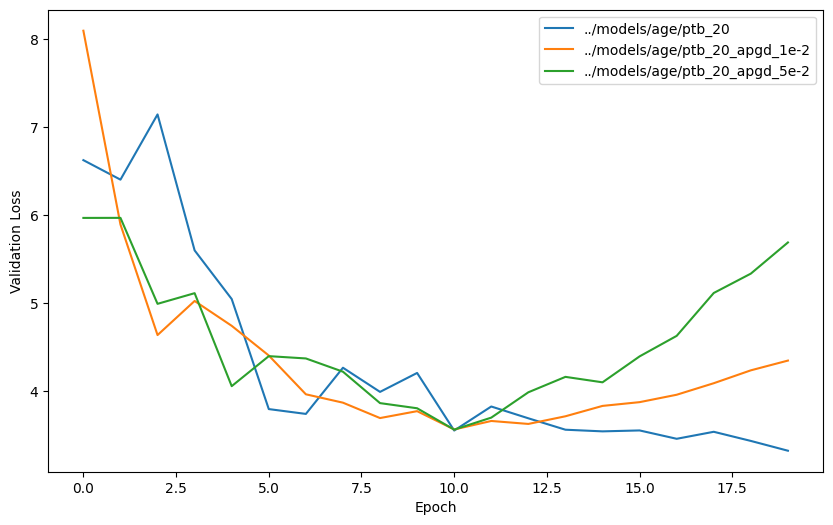

In [3]:
# Load metrics for the three models and plot them
plt.figure(figsize=(10, 6))

for model_name in ["../models/age/ptb_20", "../models/age/ptb_20_apgd_1e-2", "../models/age/ptb_20_apgd_5e-2"]:
    metrics = torch.load(model_name + '/metrics.pth')
    plt.plot(metrics['valid_loss'], label=model_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.show()
    